# Installs

In [1]:
!pip install transformers[torch,sentencepiece]

In [2]:
!pip install "sentence-transformers>=3.0.0"

In [3]:
!pip install haystack-ai datasets ollama-haystack gradio

In [4]:
!pip install ollama-haystack

# Imports

In [5]:
import pandas as pd

In [6]:
from datasets import load_dataset
from haystack import Document, Pipeline
from haystack.document_stores.in_memory import InMemoryDocumentStore
from haystack.components.retrievers import InMemoryBM25Retriever
from haystack.components.builders import PromptBuilder
from haystack_integrations.components.generators.ollama import OllamaGenerator
from haystack.document_stores.types import DuplicatePolicy
from haystack.components.embedders import SentenceTransformersTextEmbedder
from haystack.components.retrievers import InMemoryEmbeddingRetriever
from haystack.components.rankers import TransformersSimilarityRanker
from haystack.components.embedders import SentenceTransformersDocumentEmbedder
from haystack.components.writers import DocumentWriter
from haystack.components.joiners.document_joiner import DocumentJoiner

/home/luis/UFV/RAG - LLM - Jupyter/myenv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/luis/UFV/RAG - LLM - Jupyter/myenv/lib/python3.12/site-packages/haystack/core/errors.py:34: DeprecationWarning: PipelineMaxLoops is deprecated and will be remove in version '2.7.0'; use PipelineMaxComponentRuns instead.
  warnings.warn(


# Datasets

In [9]:
import pandas as pd

In [7]:
df_vuln = pd.read_parquet('/home/luis/UFV/RAG - LLM - Jupyter/dataset_reentrancy_small_multilabel.parquet')
df_vuln = df_vuln.drop_duplicates()

df_safe = pd.read_parquet('/home/luis/UFV/RAG - LLM - Jupyter/dataset_safe_small_multilabel.parquet')
df_safe = df_safe.drop_duplicates()

df_total = pd.concat([df_vuln, df_safe], ignore_index=True)
df_total = df_total.sort_values(by='source_code', key=lambda col: col.str.len(), ascending=True)
df_total.head(5)

,source_code,slither
3757,contract noFoundationProposal {},safe
1854,pragma solidity ^0.4.21;\n\n\n\ncontract Press...,safe
1630,pragma solidity ^0.4.11;\n\ncontract IconomiBl...,safe
2184,pragma solidity ^0.4.19;\n\n//Created by Moozi...,safe
3505,//SPDX-License-Identifier: Unlicense\npragma s...,safe


In [12]:
def lista(df):
  media_tamanho = df["source_code"].str.len().mean()

  # Calcula a diferença entre o tamanho de cada string e a média
  df["diferenca_media"] = abs(df["source_code"].str.len() - media_tamanho)

  # Ordena o DataFrame pela diferença e seleciona as 5 primeiras linhas
  df_selecionado = df.sort_values(by="diferenca_media")

  # Exibe o DataFrame resultante sem a coluna auxiliar de diferença
  df_selecionado = df_selecionado.drop(columns=["diferenca_media"])

  return df_selecionado['source_code'].head(5).tolist()

In [8]:
document_store = InMemoryDocumentStore(embedding_similarity_function="cosine")

documents  = [Document(content=row['source_code']) for index, row in df_vuln.iterrows()]

document_embedder  = SentenceTransformersDocumentEmbedder(model="mixedbread-ai/deepset-mxbai-embed-de-large-v1")
#document_embedder  = SentenceTransformersDocumentEmbedder()
document_embedder.warm_up()

documents_with_embeddings = document_embedder.run(documents )["documents"]
document_store.write_documents(documents_with_embeddings)

Batches: 100%|██████████████████████████████████| 51/51 [01:31<00:00,  1.79s/it]


1614

# Pipeline

In [9]:
template = """
You are an AI auditor specialized in analyzing smart contracts to detect vulnerabilities using a Retrieval-Augmented Generation (RAG) system. The following information has been retrieved from a knowledge base related to possible reentrancy issues in smart contracts.

Context:
{% for document in documents %}
    {{ document.content }}
{% endfor %}
<|eot_id|>

Carefully inspect the provided smart contract code, focusing solely on identifying reentrancy vulnerabilities. Respond **only** with a single word: "Yes" or "No". Avoid any explanations or additional details. Provide just one word: "Yes" or "No".

Smart Contract Code: {{query}}
<|eot_id|>

"""

In [10]:
text_embedder = SentenceTransformersTextEmbedder(model="mixedbread-ai/deepset-mxbai-embed-de-large-v1")

embedding_retriever = InMemoryEmbeddingRetriever(document_store=document_store, top_k = 1)

bm25_retriever = InMemoryBM25Retriever(document_store=document_store, top_k = 1)

document_joiner = DocumentJoiner(join_mode="merge")

ranker = TransformersSimilarityRanker(top_k = 1)

prompt_builder = PromptBuilder(template=template)

llm = OllamaGenerator(model="codellama:7b",
                            url = "http://localhost:11434",
                            generation_kwargs={
                              "num_predict": 100,
                              "temperature": 0.1,
                              "timeout": 500
                              #"max_tokens": 200,
                              #"stop": ["<|eot_id|>"]
                              })

In [11]:
rag_pipeline = Pipeline()

rag_pipeline.add_component("text_embedder", instance = text_embedder)
rag_pipeline.add_component("embedding_retriever", embedding_retriever)
rag_pipeline.add_component("bm25_retriever", bm25_retriever)
rag_pipeline.add_component("document_joiner", document_joiner)
rag_pipeline.add_component("ranker", ranker)
rag_pipeline.add_component("prompt_builder", prompt_builder)
rag_pipeline.add_component("generator", instance = llm)

In [12]:
rag_pipeline.connect("text_embedder", "embedding_retriever")
rag_pipeline.connect("bm25_retriever", "document_joiner")
rag_pipeline.connect("embedding_retriever", "document_joiner")
rag_pipeline.connect("document_joiner", "ranker")
rag_pipeline.connect("ranker", "prompt_builder.documents")
rag_pipeline.connect("prompt_builder", "generator")


🚅 Components
  - text_embedder: SentenceTransformersTextEmbedder
  - embedding_retriever: InMemoryEmbeddingRetriever
  - bm25_retriever: InMemoryBM25Retriever
  - document_joiner: DocumentJoiner
  - ranker: TransformersSimilarityRanker
  - prompt_builder: PromptBuilder
  - generator: OllamaGenerator
🛤️ Connections
  - text_embedder.embedding -> embedding_retriever.query_embedding (List[float])
  - embedding_retriever.documents -> document_joiner.documents (List[Document])
  - bm25_retriever.documents -> document_joiner.documents (List[Document])
  - document_joiner.documents -> ranker.documents (List[Document])
  - ranker.documents -> prompt_builder.documents (List[Document])
  - prompt_builder.prompt -> generator.prompt (str)

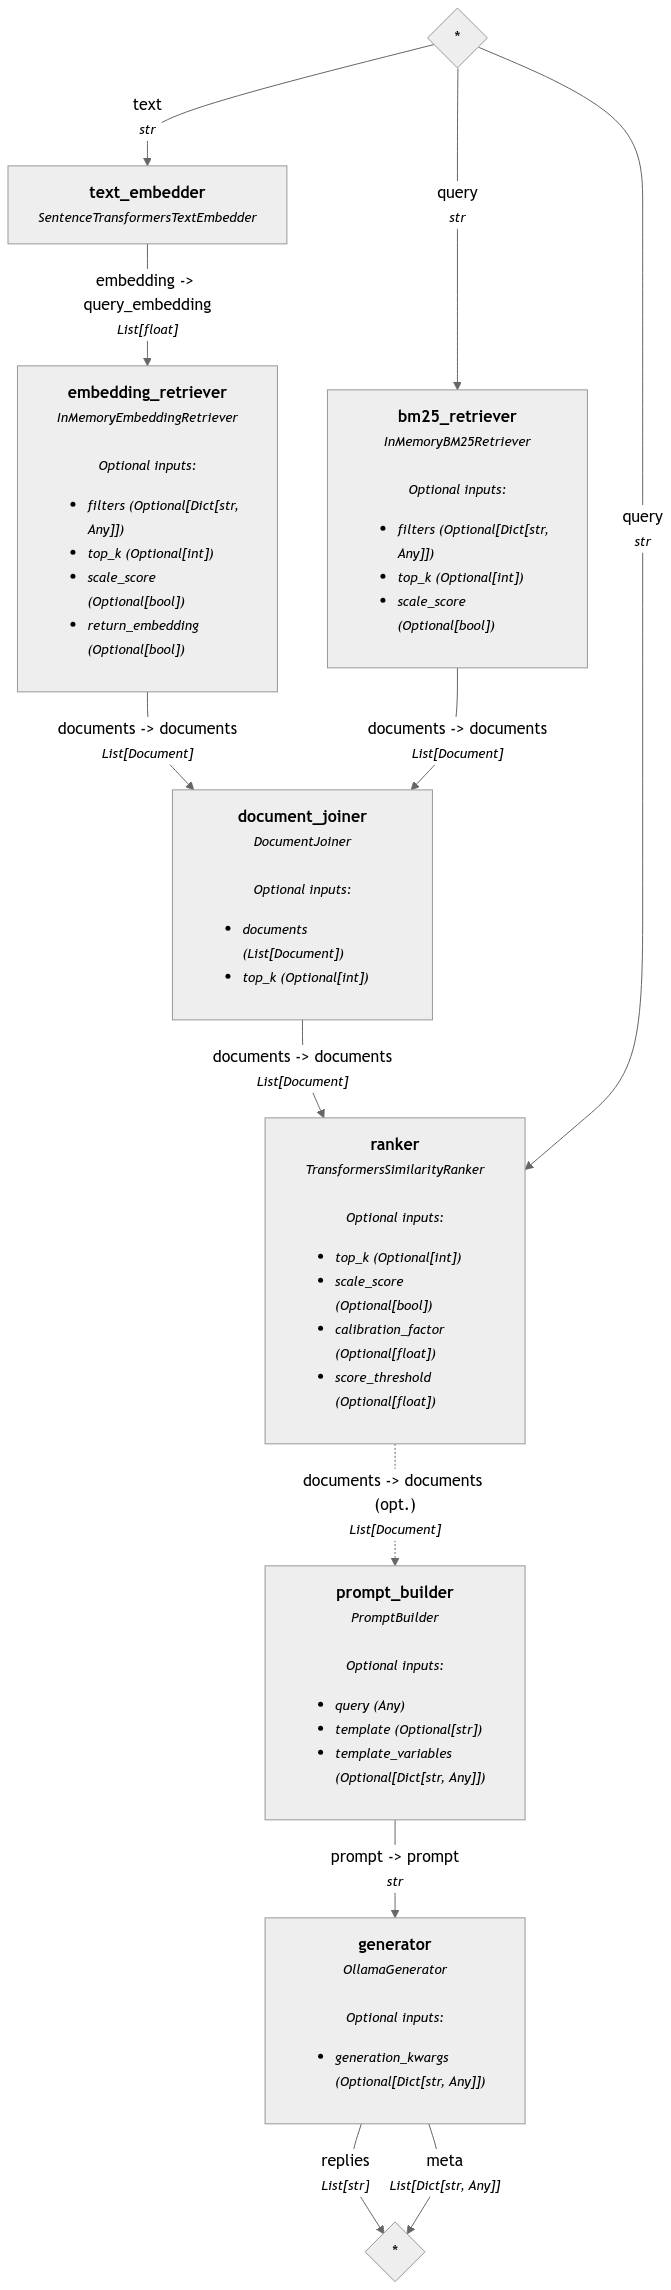

In [25]:
rag_pipeline.show()

# Execução

In [13]:
question="""
// SPDX-License-Identifier: MIT
pragma solidity ^0.8.0;

contract SimpleBank {
    mapping(address => uint256) public balances;

    function deposit() public payable {
        balances[msg.sender] += msg.value;
    }

    function withdraw(uint256 amount) public {
        require(balances[msg.sender] >= amount, "Insufficient balance");

        (bool success, ) = msg.sender.call{value: amount}("");
        require(success, "Transfer failed");

        balances[msg.sender] -= amount;
    }

    receive() external payable {}
}
"""

In [14]:
resposta = rag_pipeline.run(
  {
      #"document_embedder": {"documents": documents_with_embeddings},
      "document_joiner": {"documents": documents_with_embeddings},
      "text_embedder": {"text": question},
      "ranker": {"query": question},
      "bm25_retriever": {"query": question},
      "prompt_builder": {"query": question}
  }
)
print(resposta["generator"]["replies"][0])

Batches: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 46.79it/s]



No


In [24]:
resposta = rag_pipeline.run(
  {
      #"document_embedder": {"documents": documents_with_embeddings},
      "document_joiner": {"documents": documents_with_embeddings},
      "text_embedder": {"text": df.iloc[0,0]},
      "ranker": {"query": df.iloc[0,0]},
      "bm25_retriever": {"query": df.iloc[0,0]},
      "prompt_builder": {"query": df.iloc[0,0]}
  }
)
print(resposta["generator"]["replies"][0])

Batches: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 22.58it/s]



Yes


In [27]:
print(df.iloc[0,1])

access-control, reentrancy, other, unchecked-calls, bad-randomness, arithmetic


In [ ]:
# Itera sobre as linhas do DataFrame
for index, row in df_total.iterrows():
    # Executa o pipeline usando o conteúdo da coluna "source_code"
    resposta = rag_pipeline.run(
      {
          "document_joiner": {"documents": documents_with_embeddings},
          "text_embedder": {"text": row["source_code"]},   # Usando a coluna "source_code"
          "ranker": {"query": row["source_code"]},
          "bm25_retriever": {"query": row["source_code"]},
          "prompt_builder": {"query": row["source_code"]}
      }
    )
    
    # Exibe a resposta da LLM
    llm_resposta = resposta['generator']['replies'][0]
    print(f"LLM linha {index}: {llm_resposta}")
    
    # Verifica se a coluna "slither" contém a palavra "reentrancy"
    if "reentrancy" in row["slither"]:
        print(f"SLither linha {index} \nYes")
    else:
        print(f"Slither linha {index} \nNo")

In [ ]:
TP, FP, TN, FN = 0, 0, 0, 0

#itera sobre o DataFrame
for index, row in df_total.iterrows():
    resposta = rag_pipeline.run(
      {
          "document_joiner": {"documents": documents_with_embeddings},
          "text_embedder": {"text": row["source_code"]},  # Usando a coluna "source_code"
          "ranker": {"query": row["source_code"]},
          "bm25_retriever": {"query": row["source_code"]},
          "prompt_builder": {"query": row["source_code"]}
      }
    )
    
    llm_resposta = resposta['generator']['replies'][0]
    llm_resposta = llm_resposta.strip().lower()  #minusculo (yes' ou 'no')
    print(f"LLM linha {index}: {llm_resposta}")
    
    #verifica se a coluna "slither" tem a palavra "reentrancy"
    if "reentrancy" in row["slither"].lower():
        slither_resposta = 'yes'
    else:
        slither_resposta = 'no'
    print(f"Slither linha {index}: {slither_resposta}")
    
    #calcula as métricas de TP, FP, TN e FN
    if slither_resposta == 'yes' and llm_resposta == 'yes':
        TP += 1
    elif slither_resposta == 'no' and llm_resposta == 'yes':
        FP += 1
    elif slither_resposta == 'no' and llm_resposta == 'no':
        TN += 1
    elif slither_resposta == 'yes' and llm_resposta == 'no':
        FN += 1
    
    #exibe as métricas após cada iteração
    print(f"Metrics after line {index}: TP={TP}, FP={FP}, TN={TN}, FN={FN}\n")

Batches: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 42.02it/s]


LLM linha 3757: no
Slither linha 3757: no
Metrics after line 3757: TP=0, FP=0, TN=1, FN=0



Batches: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 111.75it/s]


LLM linha 1854: yes
Slither linha 1854: no
Metrics after line 1854: TP=0, FP=1, TN=1, FN=0



Batches: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 95.70it/s]


LLM linha 1630: no
Slither linha 1630: no
Metrics after line 1630: TP=0, FP=1, TN=2, FN=0



Batches: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 92.30it/s]


LLM linha 2184: yes
Slither linha 2184: no
Metrics after line 2184: TP=0, FP=2, TN=2, FN=0



Batches: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 94.81it/s]


LLM linha 3505: yes
Slither linha 3505: no
Metrics after line 3505: TP=0, FP=3, TN=2, FN=0



Batches: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 103.57it/s]


LLM linha 2401: yes
Slither linha 2401: no
Metrics after line 2401: TP=0, FP=4, TN=2, FN=0



Batches: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 94.49it/s]


LLM linha 2807: yes
Slither linha 2807: no
Metrics after line 2807: TP=0, FP=5, TN=2, FN=0



Batches: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 88.26it/s]


LLM linha 1719: no
Slither linha 1719: no
Metrics after line 1719: TP=0, FP=5, TN=3, FN=0



Batches: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 96.44it/s]


LLM linha 2879: yes
Slither linha 2879: no
Metrics after line 2879: TP=0, FP=6, TN=3, FN=0



Batches: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 71.30it/s]


LLM linha 2685: no
Slither linha 2685: no
Metrics after line 2685: TP=0, FP=6, TN=4, FN=0



Batches: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 74.53it/s]


LLM linha 1972: no
Slither linha 1972: no
Metrics after line 1972: TP=0, FP=6, TN=5, FN=0



Batches: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 71.84it/s]


LLM linha 2409: yes
Slither linha 2409: no
Metrics after line 2409: TP=0, FP=7, TN=5, FN=0



Batches: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 71.98it/s]


LLM linha 2899: yes
Slither linha 2899: no
Metrics after line 2899: TP=0, FP=8, TN=5, FN=0



Batches: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 72.83it/s]


LLM linha 3278: yes
Slither linha 3278: no
Metrics after line 3278: TP=0, FP=9, TN=5, FN=0



Batches: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 75.83it/s]


LLM linha 2444: yes
Slither linha 2444: no
Metrics after line 2444: TP=0, FP=10, TN=5, FN=0



Batches: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 64.23it/s]


LLM linha 2272: yes
Slither linha 2272: no
Metrics after line 2272: TP=0, FP=11, TN=5, FN=0



Batches: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 72.83it/s]


LLM linha 1687: yes
Slither linha 1687: no
Metrics after line 1687: TP=0, FP=12, TN=5, FN=0



Batches: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 63.84it/s]


LLM linha 3525: yes
Slither linha 3525: no
Metrics after line 3525: TP=0, FP=13, TN=5, FN=0



Batches: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 63.15it/s]


LLM linha 2707: yes
Slither linha 2707: no
Metrics after line 2707: TP=0, FP=14, TN=5, FN=0



Batches: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 63.85it/s]


LLM linha 1706: yes
Slither linha 1706: no
Metrics after line 1706: TP=0, FP=15, TN=5, FN=0



Batches: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 48.30it/s]


LLM linha 2077: yes
Slither linha 2077: no
Metrics after line 2077: TP=0, FP=16, TN=5, FN=0



Batches: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 64.93it/s]


LLM linha 3233: yes
Slither linha 3233: no
Metrics after line 3233: TP=0, FP=17, TN=5, FN=0



Batches: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 61.16it/s]


LLM linha 2412: no
Slither linha 2412: no
Metrics after line 2412: TP=0, FP=17, TN=6, FN=0



Batches: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 46.76it/s]


LLM linha 3762: yes
Slither linha 3762: no
Metrics after line 3762: TP=0, FP=18, TN=6, FN=0



Batches: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 65.41it/s]


LLM linha 2512: yes
Slither linha 2512: no
Metrics after line 2512: TP=0, FP=19, TN=6, FN=0



Batches: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 48.66it/s]


LLM linha 3618: yes
Slither linha 3618: no
Metrics after line 3618: TP=0, FP=20, TN=6, FN=0



Batches: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 47.01it/s]


LLM linha 3135: yes
Slither linha 3135: no
Metrics after line 3135: TP=0, FP=21, TN=6, FN=0



Batches: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 62.60it/s]


LLM linha 3377: yes
Slither linha 3377: no
Metrics after line 3377: TP=0, FP=22, TN=6, FN=0



Batches: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 48.35it/s]


LLM linha 2632: no
Slither linha 2632: no
Metrics after line 2632: TP=0, FP=22, TN=7, FN=0



Batches: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 64.49it/s]


LLM linha 3262: no
Slither linha 3262: no
Metrics after line 3262: TP=0, FP=22, TN=8, FN=0



Batches: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 63.49it/s]


LLM linha 1683: yes
Slither linha 1683: no
Metrics after line 1683: TP=0, FP=23, TN=8, FN=0



Batches: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 47.93it/s]


LLM linha 2938: yes
Slither linha 2938: no
Metrics after line 2938: TP=0, FP=24, TN=8, FN=0



Batches: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 62.44it/s]


LLM linha 2535: yes
Slither linha 2535: no
Metrics after line 2535: TP=0, FP=25, TN=8, FN=0



Batches: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 77.09it/s]


LLM linha 2345: yes
Slither linha 2345: no
Metrics after line 2345: TP=0, FP=26, TN=8, FN=0



Batches: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 46.92it/s]


LLM linha 2156: no
Slither linha 2156: no
Metrics after line 2156: TP=0, FP=26, TN=9, FN=0



Batches: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 47.24it/s]


LLM linha 1718: yes
Slither linha 1718: no
Metrics after line 1718: TP=0, FP=27, TN=9, FN=0



Batches: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 46.55it/s]


LLM linha 2757: no
Slither linha 2757: no
Metrics after line 2757: TP=0, FP=27, TN=10, FN=0



Batches: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 46.31it/s]


LLM linha 2903: yes
Slither linha 2903: no
Metrics after line 2903: TP=0, FP=28, TN=10, FN=0



Batches: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 47.07it/s]


LLM linha 3056: yes
Slither linha 3056: no
Metrics after line 3056: TP=0, FP=29, TN=10, FN=0



Batches: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 50.67it/s]


LLM linha 2038: yes
Slither linha 2038: no
Metrics after line 2038: TP=0, FP=30, TN=10, FN=0



Batches: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 48.31it/s]


LLM linha 2650: yes
Slither linha 2650: no
Metrics after line 2650: TP=0, FP=31, TN=10, FN=0



Batches: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 50.00it/s]


LLM linha 2940: yes
Slither linha 2940: no
Metrics after line 2940: TP=0, FP=32, TN=10, FN=0



Batches: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 47.22it/s]


LLM linha 2268: yes
Slither linha 2268: no
Metrics after line 2268: TP=0, FP=33, TN=10, FN=0



Batches: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 39.00it/s]


LLM linha 2298: yes
Slither linha 2298: no
Metrics after line 2298: TP=0, FP=34, TN=10, FN=0



Batches: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 47.26it/s]


LLM linha 2633: yes
Slither linha 2633: no
Metrics after line 2633: TP=0, FP=35, TN=10, FN=0



Batches: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 53.10it/s]


LLM linha 2127: yes
Slither linha 2127: no
Metrics after line 2127: TP=0, FP=36, TN=10, FN=0



Batches: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 37.47it/s]


LLM linha 1879: no
Slither linha 1879: no
Metrics after line 1879: TP=0, FP=36, TN=11, FN=0



Batches: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 38.95it/s]


LLM linha 3327: yes
Slither linha 3327: no
Metrics after line 3327: TP=0, FP=37, TN=11, FN=0



Batches: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 37.80it/s]


LLM linha 3076: yes
Slither linha 3076: no
Metrics after line 3076: TP=0, FP=38, TN=11, FN=0



Batches: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 35.14it/s]


LLM linha 2133: yes
Slither linha 2133: no
Metrics after line 2133: TP=0, FP=39, TN=11, FN=0



Batches: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 37.47it/s]


LLM linha 2501: yes
Slither linha 2501: no
Metrics after line 2501: TP=0, FP=40, TN=11, FN=0



Batches: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 50.01it/s]


LLM linha 2852: yes
Slither linha 2852: no
Metrics after line 2852: TP=0, FP=41, TN=11, FN=0



Batches: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 39.22it/s]


LLM linha 2684: yes
Slither linha 2684: no
Metrics after line 2684: TP=0, FP=42, TN=11, FN=0



Batches: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 30.23it/s]


LLM linha 1692: no
Slither linha 1692: no
Metrics after line 1692: TP=0, FP=42, TN=12, FN=0



Batches: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 35.97it/s]


LLM linha 1950: yes
Slither linha 1950: no
Metrics after line 1950: TP=0, FP=43, TN=12, FN=0



Batches: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 38.58it/s]


LLM linha 2892: no
Slither linha 2892: no
Metrics after line 2892: TP=0, FP=43, TN=13, FN=0



Batches: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 39.24it/s]


LLM linha 3571: no
Slither linha 3571: no
Metrics after line 3571: TP=0, FP=43, TN=14, FN=0



Batches: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 39.63it/s]


LLM linha 3746: yes
Slither linha 3746: no
Metrics after line 3746: TP=0, FP=44, TN=14, FN=0



Batches: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 38.03it/s]


LLM linha 3431: yes
Slither linha 3431: no
Metrics after line 3431: TP=0, FP=45, TN=14, FN=0



Batches: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 39.47it/s]


LLM linha 3758: yes
Slither linha 3758: no
Metrics after line 3758: TP=0, FP=46, TN=14, FN=0



Batches: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 38.86it/s]


LLM linha 3197: yes
Slither linha 3197: no
Metrics after line 3197: TP=0, FP=47, TN=14, FN=0



Batches: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 39.73it/s]


LLM linha 3353: yes
Slither linha 3353: no
Metrics after line 3353: TP=0, FP=48, TN=14, FN=0



Batches: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 37.02it/s]


LLM linha 2860: yes
Slither linha 2860: no
Metrics after line 2860: TP=0, FP=49, TN=14, FN=0



Batches: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 35.12it/s]


LLM linha 2221: yes
Slither linha 2221: no
Metrics after line 2221: TP=0, FP=50, TN=14, FN=0



Batches: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 37.68it/s]


LLM linha 2666: yes
Slither linha 2666: no
Metrics after line 2666: TP=0, FP=51, TN=14, FN=0



Batches: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 36.53it/s]


LLM linha 3061: no
Slither linha 3061: no
Metrics after line 3061: TP=0, FP=51, TN=15, FN=0



Batches: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 37.46it/s]


LLM linha 2534: yes
Slither linha 2534: no
Metrics after line 2534: TP=0, FP=52, TN=15, FN=0



Batches: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 37.20it/s]


LLM linha 2988: yes
Slither linha 2988: no
Metrics after line 2988: TP=0, FP=53, TN=15, FN=0



Batches: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 37.16it/s]


LLM linha 2282: yes
Slither linha 2282: no
Metrics after line 2282: TP=0, FP=54, TN=15, FN=0



Batches: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 26.48it/s]


LLM linha 1629: no
Slither linha 1629: no
Metrics after line 1629: TP=0, FP=54, TN=16, FN=0



Batches: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 37.30it/s]


LLM linha 3756: yes
Slither linha 3756: no
Metrics after line 3756: TP=0, FP=55, TN=16, FN=0



Batches: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 29.03it/s]


LLM linha 2062: yes
Slither linha 2062: no
Metrics after line 2062: TP=0, FP=56, TN=16, FN=0



Batches: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 28.09it/s]


LLM linha 2749: yes
Slither linha 2749: no
Metrics after line 2749: TP=0, FP=57, TN=16, FN=0



Batches: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 30.60it/s]


LLM linha 1774: no
Slither linha 1774: no
Metrics after line 1774: TP=0, FP=57, TN=17, FN=0



Batches: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 28.39it/s]


LLM linha 1846: yes
Slither linha 1846: no
Metrics after line 1846: TP=0, FP=58, TN=17, FN=0



Batches: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 38.11it/s]


LLM linha 2563: no
Slither linha 2563: no
Metrics after line 2563: TP=0, FP=58, TN=18, FN=0



Batches: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 39.33it/s]


LLM linha 2645: no
Slither linha 2645: no
Metrics after line 2645: TP=0, FP=58, TN=19, FN=0



Batches: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 37.32it/s]


LLM linha 3628: yes
Slither linha 3628: no
Metrics after line 3628: TP=0, FP=59, TN=19, FN=0



Batches: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 28.51it/s]


LLM linha 2320: no
Slither linha 2320: no
Metrics after line 2320: TP=0, FP=59, TN=20, FN=0



Batches: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 28.36it/s]


LLM linha 3709: yes
Slither linha 3709: no
Metrics after line 3709: TP=0, FP=60, TN=20, FN=0



Batches: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 27.78it/s]


LLM linha 2181: yes
Slither linha 2181: no
Metrics after line 2181: TP=0, FP=61, TN=20, FN=0



Batches: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 36.38it/s]


LLM linha 1816: no
Slither linha 1816: no
Metrics after line 1816: TP=0, FP=61, TN=21, FN=0



Batches: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 28.85it/s]


LLM linha 2791: yes
Slither linha 2791: no
Metrics after line 2791: TP=0, FP=62, TN=21, FN=0



Batches: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 33.99it/s]


LLM linha 2999: no
Slither linha 2999: no
Metrics after line 2999: TP=0, FP=62, TN=22, FN=0



Batches: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 22.55it/s]


LLM linha 1252: yes
Slither linha 1252: yes
Metrics after line 1252: TP=1, FP=62, TN=22, FN=0



Batches: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 35.96it/s]


LLM linha 2248: yes
Slither linha 2248: no
Metrics after line 2248: TP=1, FP=63, TN=22, FN=0



Batches: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 24.66it/s]


LLM linha 2700: no
Slither linha 2700: no
Metrics after line 2700: TP=1, FP=63, TN=23, FN=0



Batches: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 24.24it/s]


LLM linha 3627: yes. this smart contract has a reentrancy vulnerability due to the use of `emit` in the `logrepay` and `logboost` functions. when these events are emitted, they trigger a call to the `compoundlogger` contract's `repay` or `boost` function, which can potentially cause a reentrancy attack if the `compoundlogger` contract is not designed with reentrancy in mind.
Slither linha 3627: no
Metrics after line 3627: TP=1, FP=63, TN=23, FN=0



Batches: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 25.55it/s]


LLM linha 2353: no
Slither linha 2353: no
Metrics after line 2353: TP=1, FP=63, TN=24, FN=0



Batches: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 22.30it/s]


LLM linha 2217: yes
Slither linha 2217: no
Metrics after line 2217: TP=1, FP=64, TN=24, FN=0



Batches: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 25.56it/s]


LLM linha 3332: yes
Slither linha 3332: no
Metrics after line 3332: TP=1, FP=65, TN=24, FN=0



Batches: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 21.24it/s]


LLM linha 1992: yes
Slither linha 1992: no
Metrics after line 1992: TP=1, FP=66, TN=24, FN=0



Batches: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 34.68it/s]


LLM linha 1681: no
Slither linha 1681: no
Metrics after line 1681: TP=1, FP=66, TN=25, FN=0



Batches: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 35.47it/s]


LLM linha 2280: no
Slither linha 2280: no
Metrics after line 2280: TP=1, FP=66, TN=26, FN=0



Batches: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 23.69it/s]


LLM linha 2977: no
Slither linha 2977: no
Metrics after line 2977: TP=1, FP=66, TN=27, FN=0



Batches: 100%|████████████████████████████████████| 1/1 [00:00<00:00,  8.85it/s]


LLM linha 1985: yes
Slither linha 1985: no
Metrics after line 1985: TP=1, FP=67, TN=27, FN=0



Batches: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 14.32it/s]


LLM linha 1254: yes
Slither linha 1254: yes
Metrics after line 1254: TP=2, FP=67, TN=27, FN=0



Batches: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 14.49it/s]


LLM linha 3023: no
Slither linha 3023: no
Metrics after line 3023: TP=2, FP=67, TN=28, FN=0



Batches: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 16.52it/s]


LLM linha 2634: yes
Slither linha 2634: no
Metrics after line 2634: TP=2, FP=68, TN=28, FN=0



Batches: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 10.86it/s]


LLM linha 1729: no
Slither linha 1729: no
Metrics after line 1729: TP=2, FP=68, TN=29, FN=0



Batches: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 26.67it/s]


LLM linha 1698: yes
Slither linha 1698: no
Metrics after line 1698: TP=2, FP=69, TN=29, FN=0



Batches: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 18.61it/s]


LLM linha 3216: yes
Slither linha 3216: no
Metrics after line 3216: TP=2, FP=70, TN=29, FN=0



Batches: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 17.13it/s]


LLM linha 2894: yes
Slither linha 2894: no
Metrics after line 2894: TP=2, FP=71, TN=29, FN=0



Batches: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 18.13it/s]


LLM linha 1882: no
Slither linha 1882: no
Metrics after line 1882: TP=2, FP=71, TN=30, FN=0



Batches: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 13.10it/s]


LLM linha 3398: yes
Slither linha 3398: no
Metrics after line 3398: TP=2, FP=72, TN=30, FN=0



Batches: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 15.01it/s]


LLM linha 2888: yes
Slither linha 2888: no
Metrics after line 2888: TP=2, FP=73, TN=30, FN=0



Batches: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 13.82it/s]


LLM linha 3550: yes
Slither linha 3550: no
Metrics after line 3550: TP=2, FP=74, TN=30, FN=0



Batches: 100%|████████████████████████████████████| 1/1 [00:00<00:00,  9.53it/s]


LLM linha 3094: yes
Slither linha 3094: no
Metrics after line 3094: TP=2, FP=75, TN=30, FN=0



Batches: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 11.70it/s]


LLM linha 2382: no
Slither linha 2382: no
Metrics after line 2382: TP=2, FP=75, TN=31, FN=0



Batches: 100%|████████████████████████████████████| 1/1 [00:00<00:00,  8.60it/s]


LLM linha 2889: yes
Slither linha 2889: no
Metrics after line 2889: TP=2, FP=76, TN=31, FN=0



Batches: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 17.77it/s]


LLM linha 567: yes
Slither linha 567: yes
Metrics after line 567: TP=3, FP=76, TN=31, FN=0



Batches: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 12.70it/s]


LLM linha 2347: the provided code is a solidity smart contract named `nonreceivableinitializedproxy`. it has a constructor that takes two parameters: `_logic` and `_initializationcalldata`. the constructor sets the value of the `logic` variable to `_logic`, and then delegates a call to the `_logic` contract with the `_initializationcalldata` as calldata.

the fallback function is also present in this contract, which simply delegates a
Slither linha 2347: no
Metrics after line 2347: TP=3, FP=76, TN=31, FN=0



Batches: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 11.09it/s]


LLM linha 2101: yes
Slither linha 2101: no
Metrics after line 2101: TP=3, FP=77, TN=31, FN=0



Batches: 100%|████████████████████████████████████| 1/1 [00:00<00:00,  3.84it/s]


LLM linha 3090: yes
Slither linha 3090: no
Metrics after line 3090: TP=3, FP=78, TN=31, FN=0



Batches: 100%|████████████████████████████████████| 1/1 [00:00<00:00,  5.04it/s]


LLM linha 2627: yes
Slither linha 2627: no
Metrics after line 2627: TP=3, FP=79, TN=31, FN=0



Batches: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 10.55it/s]


LLM linha 2931: yes
Slither linha 2931: no
Metrics after line 2931: TP=3, FP=80, TN=31, FN=0



Batches: 100%|████████████████████████████████████| 1/1 [00:00<00:00,  6.27it/s]


LLM linha 2183: yes. the provided code contains a reentrancy vulnerability in the `multisend` function of the `airdrop` contract. the issue is that the function calls the `transfer` method of the token contract, which can potentially call back into the `airdrop` contract and cause a recursive loop. this can lead to unintended behavior, such as infinite loops or the accumulation of gas costs.

to fix this vulnerability, you could modify
Slither linha 2183: no
Metrics after line 2183: TP=3, FP=80, TN=31, FN=0



Batches: 100%|████████████████████████████████████| 1/1 [00:00<00:00,  4.40it/s]


LLM linha 1913: yes
Slither linha 1913: no
Metrics after line 1913: TP=3, FP=81, TN=31, FN=0



Batches: 100%|████████████████████████████████████| 1/1 [00:00<00:00,  3.90it/s]


In [1]:
TP=3
FP=81
TN=31
FN=0

accuracy = (TP + TN) / (TP + FP + TN + FN)
precision = TP / (TP + FP) if (TP + FP) != 0 else 0
recall = TP / (TP + FN) if (TP + FN) != 0 else 0
f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0

print("accuracy", accuracy)
print("precision", precision)
print("recall", recall)
print("f1", f1)

accuracy 0.2956521739130435
precision 0.03571428571428571
recall 1.0
f1 0.0689655172413793
